In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

CONFIG

In [29]:
config = {
    # config for the neural network
    "nn": {
        "window": 50, # this is also the window, window size or entries used to predict the future price
        "nLayers": 2, # 2
        "neurons": 256, # 256
        "nFeatures": 5,
        "dropout": 0.3,
        "lossFunc": "huber_loss", # "huber_loss" Huber looss is better to give outliers some weight but not too much, which can be good for predicting asset prices?
        "optimizer": "adam", # "adam"
        "layerType": LSTM, # could set it upt to be a list of the layers that need to be generated [LSTM LSTM] 2 hidden layers 
    },
    "data": {
        "ticker": "TSLA", # "TSLA" "AMZN" "AAPL" "NVDA" "AMD"
        "offset": pd.DateOffset(years = 3, months = 0, days = 0),
        "lookahead": 2,
        "validation": 0.1, # percentage of training data to be used as validation
        "testSize": 0.1, # to test on 
        "scale": True,
        "scaler": preprocessing.MinMaxScaler(),
        "inputs": ['adjclose', 'volume', 'open', 'high', 'low'],
    },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64, # 64
        "num_epoch": 100, # 500
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}
# DISPLAY AROUGH ESTIMATE OF HOW MANY DAYS WILL BE USED FOR EACH SECTION
damping = 0.9 # some extra damping for extra days that data isn't collected

offset = config["data"]["offset"]
ts1 = pd.Timestamp('2023-02-25')
ts2 = ts1 + offset
td = ts2 - ts1
days_offset = int(td.days/7*5*damping) # find out the roungh amount of days imported
print(f"{days_offset} Total days used will be roughly imported\n")
print(f"{days_offset* (1-config['data']['validation']-config['data']['testSize'])} Days used for training")
print(f"{days_offset*config['data']['validation']} Days used for validation")
print(f"{days_offset*config['data']['testSize']} Days used for testing")

704 Total days used will be roughly imported

563.2 Days used for training
70.4 Days used for validation
70.4 Days used for testing


Import all the required libraries for this proect
Keep in mind you have to install the following libraries first before this code can be run

pip install tensorflow pandas numpy matplotlib yahoo_fin scikit-learn

if the computer being used is an silicon apple chip then for tensorflow the following must be done

conda install -c apple tensorflow-deps
pip install tensorflow-macos
pip install tensorflow-metal # this is an optional but recommended

pip install pandas numpy matplotlib yahoo_fin scikit-learn

python -m pip install jupyter notebook -U

conda install -c conda-forge -y pandas jupyter


In [30]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, LSTM, Dense


"""
HERE mean_absolute_error CAN BE REPLACED BY mse?
Also need to have a look at bidirectional network and how that works and so forth

"""
def generateModel(
    window,
    n_layers=2,
    neurons=256,
    n_features=5,
    dropout=0.3,
    loss="mean_absolute_error",
    optimizer="rmsprop",
    layerType=LSTM
    ):
    # generate a keras model to linearly group a stasck of layers
    model = models.Sequential()
    # repeat for each layer
    for layer in range(n_layers):
        # check for first layer
        if layer == 0:
            """NEED TO FIGURE OUT THE DIFFERENE BETWEEN THEESE TWO LINES OF CODE, INPUT SHAPE AND BATCH INPUT SHAPE"""
            model.add(LSTM(neurons, return_sequences=True, input_shape=(window, n_features)))
            # model.add(layerType(neurons, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        # check for final layer
        elif layer == n_layers - 1:
            model.add(layerType(neurons, return_sequences=False))
        # middle/hidden layers
        else:
            model.add(layerType(neurons, return_sequences=True))

        # add dropout after each layer
        """ this layer helps prevent over fitting
        The Dropout layer randomly sets input units to 0
        with a frequency of rate at each step during training time,
        which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate)
        such that the sum over all inputs is unchanged."""
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    # compile the model once it has be compelted
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


Generate the model by setting up all the parameters:

adjclose, volume, open, high and low as the 5 inputs of the model

In [31]:
# create a model using the options in CONFIG
model = generateModel(
    config["nn"]["window"],
    config["nn"]["nLayers"],
    config["nn"]["neurons"],
    n_features= config["nn"]["nFeatures"],
    dropout= config["nn"]["dropout"],
    loss= config["nn"]["lossFunc"],
    optimizer= config["nn"]["optimizer"],
    layerType= config["nn"]["layerType"]
    )

# display the model summary
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 50, 256)           268288    
                                                                 
 dropout_128 (Dropout)       (None, 50, 256)           0         
                                                                 
 lstm_129 (LSTM)             (None, 256)               525312    
                                                                 
 dropout_129 (Dropout)       (None, 256)               0         
                                                                 
 dense_44 (Dense)            (None, 1)                 257       
                                                                 
Total params: 793,857
Trainable params: 793,857
Non-trainable params: 0
_________________________________________________________________


Visualisze the model

In [32]:
# import
from tensorflow.keras import models, layers, utils, backend as K 
import matplotlib.pyplot as plt
import numpy as np
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            # radius=y_space/4.0
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/10, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

# visualize_nn(model, description=True, figsize=(10,8)) # 10 by 8

Importing the data to be used with the neural netowork

"get_data" from "stock_info" takes the arguments:
- ticker: case insensitive ticker of the desired stock/bond
- start_date: date you want the data to start from (mm/dd/yyyy)
- end_date: date you want the data to end (mm/dd/yyyy)
- index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
- interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

DATA LOADER

In [49]:
# Import yfinance package (NEED OT DOUBLE CHEKC IF THIS IS ACTUALLY A MODEL THAT CAN BE USED)

# import yfinance as yf # make sure to unisntall if this isn't used in the future
from yahoo_fin import stock_info
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing

from collections import deque

def getData(
    ticker,
    offset
    ):
    # setup the start date and end date
    startDate = (datetime.now() - offset).date()
    endDate = datetime.now().date()
    # Get the data
    stocks = stock_info.get_data(ticker, startDate, endDate)
    # display how many days of data are being used for this
    print(f"{ticker} data has been imported between {startDate} and the {endDate}, for a total of {len(stocks)} days of data")
    # print(f"Each day contains the prices for: {stocks.columns}")
    return stocks

def setupData(
    stocks, # data to be reshaped
    window = 50, # the number of days used to predic the next value (window size or lookback perdiod)
    predAhead = 10, # the number of days ahead that you are tyring to predict
    validationSize = 0.1, # amount of data out of the training data to be used as validation
    testSize = 0.2, # the amount of data that will be  used for testing e.g. 0.2 -> 20%
    scale = True, # minmaxscaler
    scaler = preprocessing.MinMaxScaler(), # the scaler to be used
    inputs = ['adjclose', 'volume', 'open', 'high', 'low']
    ):
    # Setup a dictionary to store all the data
    data = {}
    # copy the data frame
    data["raw"] = stocks.copy()

    """This is something that really needs to be fixed in the future"""
    # I HAVE TO COPY THE STOCKS SO THAT THE ORIGINAL ONES AREN'T RETURNED? WHAT IS THIS ABOUT
    stocks = stocks.copy()
    



    # should we scale down between 0 and 1? It can make analysis easier
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in inputs:
            # scale the columns
            stocks[column] = scaler.fit_transform(np.expand_dims(stocks[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        data["column_scaler"] = column_scaler

    # create input a variable with x and y
    x = []
    y = []
    ydates = []
    for i in range(len(stocks)-window-predAhead+1):
        x.append(np.array(stocks[inputs].values[i:i+window]))
        y.append(stocks["adjclose"].values[i+window+predAhead-1])
        ydates.append(stocks.index[i+window+1])
    # convert into numpy arrays
    x = np.array(x)
    y = np.array(y)

    # store x and y into the data dictionary
    data["x"] = x
    data["y"] = y
    data["ydates"] =  ydates

    # split the dataset into training & testing sets by date
    # make sure to convert to an integer so that it can be used for indexing
    trainSamples = int((1 - testSize - validationSize) * len(x))
    valSamples = int(validationSize * len(x))
    data["xtrain"] = x[:trainSamples]
    data["ytrain"] = y[:trainSamples]

    data["xval"] = x[trainSamples:trainSamples+valSamples]
    data["yval"] = y[trainSamples:trainSamples+valSamples]

    data["xtest"]  = x[trainSamples+valSamples:]
    data["ytest"]  = y[trainSamples+valSamples:]
    
    data["trainDates"] = ydates[:trainSamples]
    data["valDates"] = ydates[trainSamples:trainSamples+valSamples]
    data["testDates"] = ydates[trainSamples+valSamples:]

    return data

In [34]:
# download data form yt
stocks = getData(config["data"]["ticker"], config["data"]["offset"])
stocks.keys()

Data is imported between 2020-02-27 and the 2023-02-27, for a total of 755 days of data
Each day contains the prices for: Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')


Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [35]:
# process the data
data = setupData(stocks, config["nn"]["window"], config["data"]["lookahead"], config["data"]["validation"], config["data"]["testSize"], config["data"]["scale"], config["data"]["scaler"], config["data"]["inputs"])
data.keys()

print(f"{data.keys()}\n\nHere are the adjusted values downloaded:")

print(data.keys())

print(len(data["raw"]))
print(len(data["ydates"]))


dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xval', 'yval', 'xtest', 'ytest', 'trainDates', 'valDates', 'testDates'])

Here are the adjusted values downloaded:
dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xval', 'yval', 'xtest', 'ytest', 'trainDates', 'valDates', 'testDates'])
755
704


Plot the data imported form the stocks

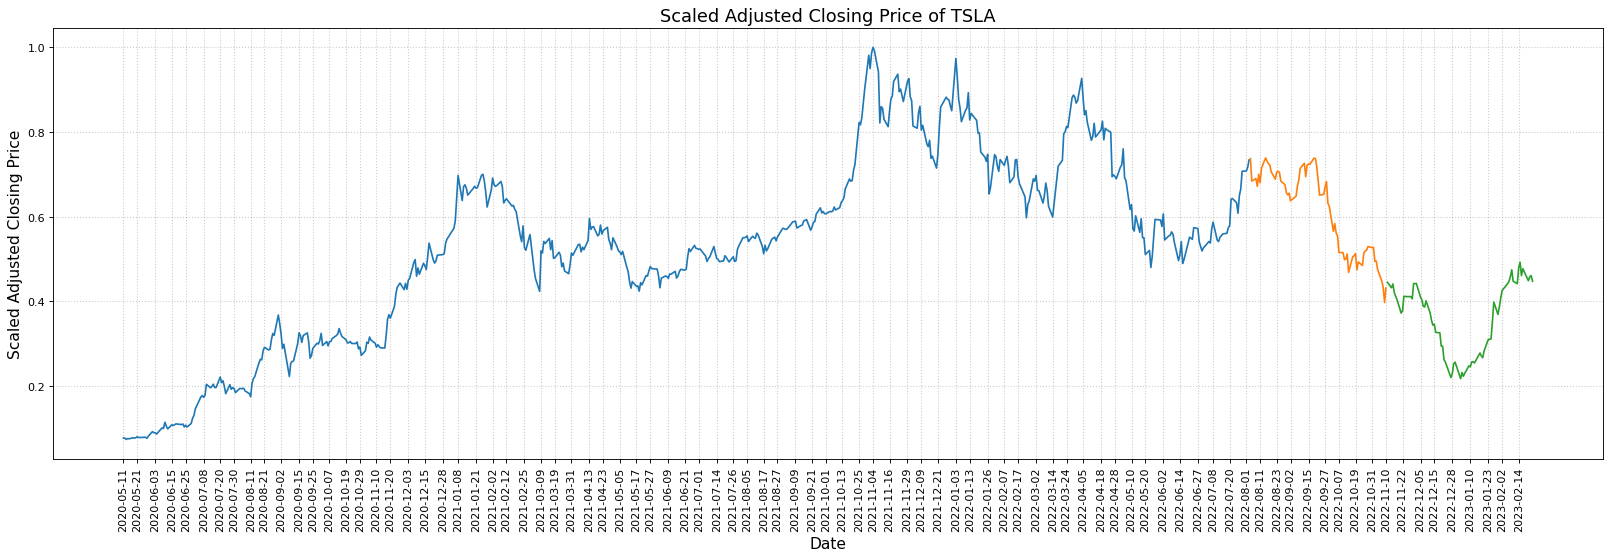

In [36]:
import matplotlib.pyplot as plt

plots = "trainDates ytrain,valDates yval,testDates ytest"
lines = 100
fig = plt.figure(figsize=(25, 7), dpi=80)
# plot all the different lines
for plot in plots.split(","):
    x, y = plot.split()
    plt.plot(data[f"{x}"], data[f"{y}"])
step = round(len(data["raw"]["adjclose"].keys())/lines)
plt.xticks(data["ydates"][::step], rotation='vertical') 
# Plot the grid lines
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
scaled = lambda x: "Scaled " if x == True else None
plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {config['data']['ticker']}", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
plt.xlabel("Date", fontsize=14)
# show the plot
plt.show()


Train the model

pip install tensorflow-macos==2.10
pip install tensorflow-metal==0.6

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

model_name = "trials"

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# Train the model by using the funciton fit
model.fit(data["xtrain"], data["ytrain"],
                    batch_size=config["training"]["batch_size"],
                    epochs=config["training"]["num_epoch"],
                    validation_data=(data["xval"], data["yval"]),
                    verbose=1) # should be able to chance verbose to 100 to display every 100 but doesn't seem to work
                    # callbacks=[checkpointer, tensorboard],


Epoch 1/100


2023-02-27 19:31:50.924346: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-27 19:31:52.314093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:52.540063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:52.701702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:52.905962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:53.101501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0474 - mean_absolute_error: 0.2371

2023-02-27 19:31:54.409420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:54.490735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:54.583800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 196ms/step - loss: 0.0474 - mean_absolute_error: 0.2371 - val_loss: 0.0084 - val_mean_absolute_error: 0.1157
Epoch 2/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0058 - mean_absolute_error: 0.0843 - val_loss: 0.0029 - val_mean_absolute_error: 0.0652
Epoch 3/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0035 - mean_absolute_error: 0.0631 - val_loss: 0.0027 - val_mean_absolute_error: 0.0585
Epoch 4/100
9/9 [==============================] - 0s 41ms/step - loss: 0.0027 - mean_absolute_error: 0.0545 - val_loss: 0.0017 - val_mean_absolute_error: 0.0486
Epoch 5/100
9/9 [==============================] - 0s 50ms/step - loss: 0.0022 - mean_absolute_error: 0.0465 - val_loss: 0.0020 - val_mean_absolute_error: 0.0498
Epoch 6/100
9/9 [==============================] - 0s 42ms/step - loss: 0.0016 - mean_absolute_error: 0.0417 - val_loss: 0.0014 - val_mean_absolute_error: 0.0439
Epoch 7/100
9/9 [======================

Plot the results

2023-02-27 19:32:34.894567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:32:34.963098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:32:35.059564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 80ms/step


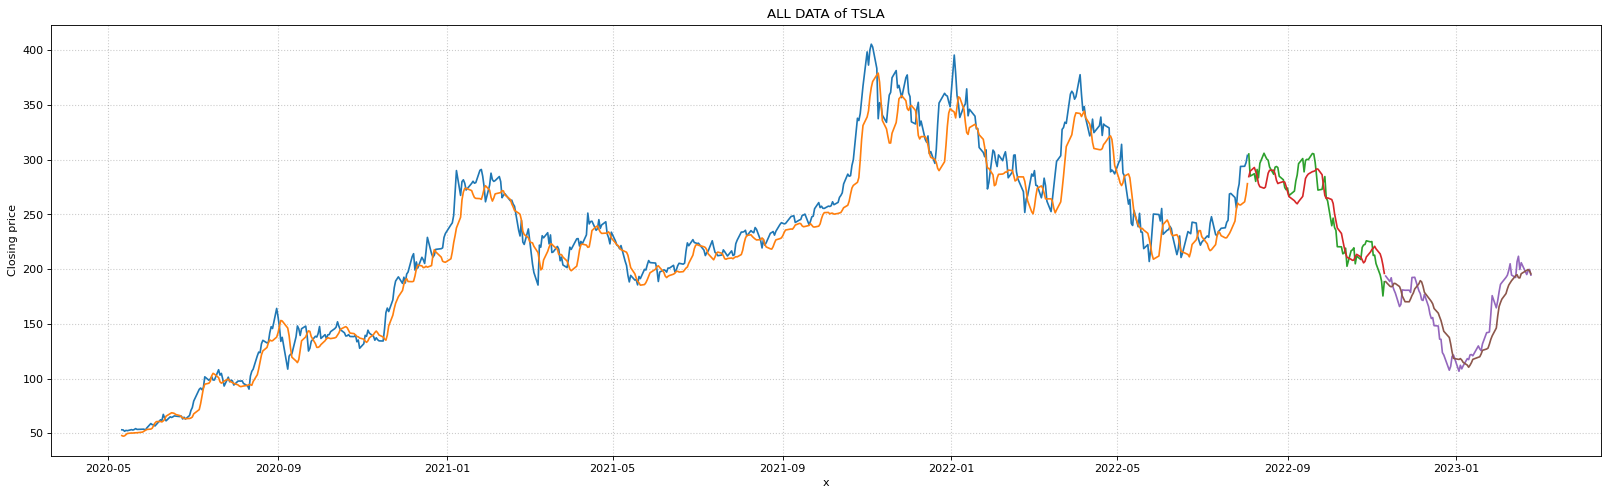

In [38]:
# for the training
pred_ytrain = model.predict(data["xtrain"])
ytrain = data["ytrain"]
# scaler = config["data"]["scaler"]
pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))


# for the training
pred_yval = model.predict(data["xval"])
yval = data["yval"]
# scaler = config["data"]["scaler"]
pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))


# for the training
pred_ytest = model.predict(data["xtest"])
ytest = data["ytest"]
# scaler = config["data"]["scaler"]
pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))





# plot the results
# # TRAINING DATA
# fig= plt.figure(figsize=(25, 7), dpi=80)
# plt.plot(ytrain)
# plt.plot(pred_ytrain)
# plt.title(f"Training data of {config['data']['ticker']}")
# plt.xlabel("x")
# plt.ylabel("Closing price")
# xticks = 100
# step = round(len(data["raw"]["adjclose"].keys())/xticks)
# plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
# plt.legend("Actual,Neural Network".split(","))
# plt.show()
# # VALIDATION DATA
# fig= plt.figure(figsize=(25, 7), dpi=80)
# plt.plot(yval, "*-") # actual data
# plt.plot(pred_yval, "*-")
# plt.title(f"Validation data of {config['data']['ticker']}")
# plt.xlabel("x")
# plt.ylabel("Closing price")
# xticks = 100
# step = round(len(data["raw"]["adjclose"].keys())/xticks)
# plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
# plt.show()
# ALL 3 TOGETHER
# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
plt.plot(data["trainDates"],ytrain) # train data
plt.plot(data["trainDates"], pred_ytrain)
plt.plot(data["valDates"], yval) # val data
plt.plot(data["valDates"], pred_yval)
plt.plot(data["testDates"], ytest) # test data
plt.plot(data["testDates"], pred_ytest)
plt.title(f"ALL DATA of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()



Other methods to compare against

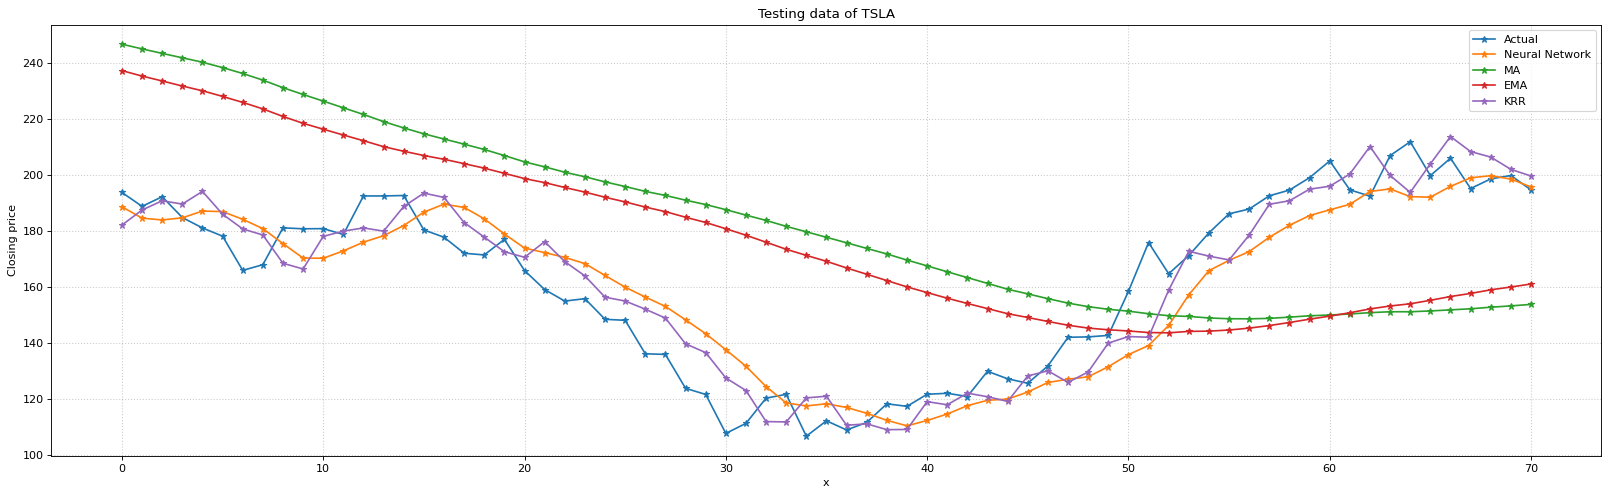

In [39]:
# TEST DATA

# Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
# Train the model on the training data
krr.fit(data['xtrain'][:, -1, :], data['ytrain'])
# Make predictions on the test data
pred_krr = krr.predict(data['xtest'][:, -1, :])
pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))


# calcualte the price using a simple moving average
pred_ma = np.mean(data["xtest"], axis = 1)
pred_ma = pred_ma[:, 0] # take only the adjclose price out
pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))

# calculate the price using exponential moving average
pred_ema = data["xtest"][:, :, 0] # only take the 
# pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
weights = np.exp(np.linspace(-1, 0, config["nn"]["window"]))
weights /= weights.sum()
pred_ema = pred_ema@weights
pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))

# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
plt.plot(ytest, "*-") # actual data
plt.plot(pred_ytest, "*-") # prediction made by neural network
plt.plot(pred_ma, "*-")
plt.plot(pred_ema, "*-")
plt.plot(pred_krr, "*-")
plt.title(f"Testing data of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
xticks = 100
step = round(len(data["raw"]["adjclose"].keys())/xticks)
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.legend("Actual,Neural Network,MA,EMA,KRR".split(","))
plt.show()

 RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %) will be our current model evaluation metrics. Both are useful measures of forecast accuracy. 

In [40]:
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# def calc_da(y_true, y_pred):
#     count = 0
#     predictions = len(y_true)-1
#     for i in range(predictions):
#         true_dir = y_true[i+1]-y_true[i]
#         pred_dir = y_pred[i+1]-y_pred[i]

#         # if true_dir > 0 and pred_dir > 0 or true_dir <= 0 and pred_dir <= 0:
#         if true_dir * pred_dir > 0:
#             count += 1
#         # print(true_grad/abs(true_grad))
#     return count/predictions
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))

# compare all the following data
pairs = [[ytrain, pred_ytrain, 'Training NN'],
         [yval, pred_yval, 'Validation NN'],
         [ytest, pred_ytest, 'Testing NN'],
         [ytest, pred_krr, 'Testing KRR'],
         [ytest, pred_ma, 'Testing MA'],
         [ytest, pred_ema, 'Testing EMA']
         ]

d = {}
for pair in pairs:
    d[pair[2]] = []
    d[pair[2]].append(calc_mse(pair[0], pair[1]))
    d[pair[2]].append(calc_rmse(pair[0], pair[1]))
    # d[pair[2]].append(calc_mae(pair[0], pair[1]))
    d[pair[2]].append(calc_mape(pair[0], pair[1]))
    d[pair[2]].append(calc_da(pair[0], pair[1]))
    d[pair[2]].append(calc_cod(pair[0], pair[1]))

df = pd.DataFrame(data=d)
df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²']
df

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,295.007437,212.245888,172.759693,117.299685,2316.624984,1798.903505
RMSE,17.175781,14.568661,13.143808,10.830498,48.131331,42.413483
MAPE,5.448532,4.751548,7.227501,5.835578,29.803178,25.905475
DA,0.482206,0.463768,0.628571,0.542857,0.514286,0.585714
R²,0.956515,0.854657,0.824787,0.881034,-1.349525,-0.824451


Trading stocks

,Neural Netowrk,KRR,Moving Average,Exp Moving Average
Percentage,70.73%,2.14%,10.17%,0.00%
Buy in,"£ 1,000.00","£ 1,000.00","£ 1,000.00","£ 1,000.00"
Cash out,"£ 1,707.28","£ 1,021.45","£ 1,101.70","£ 1,000.00"
14.0 weeks profit,£ 707.28,£ 21.45,£ 101.70,£ 0.00
Profit per month,£ 307.53,£ 9.33,£ 44.22,£ 0.00


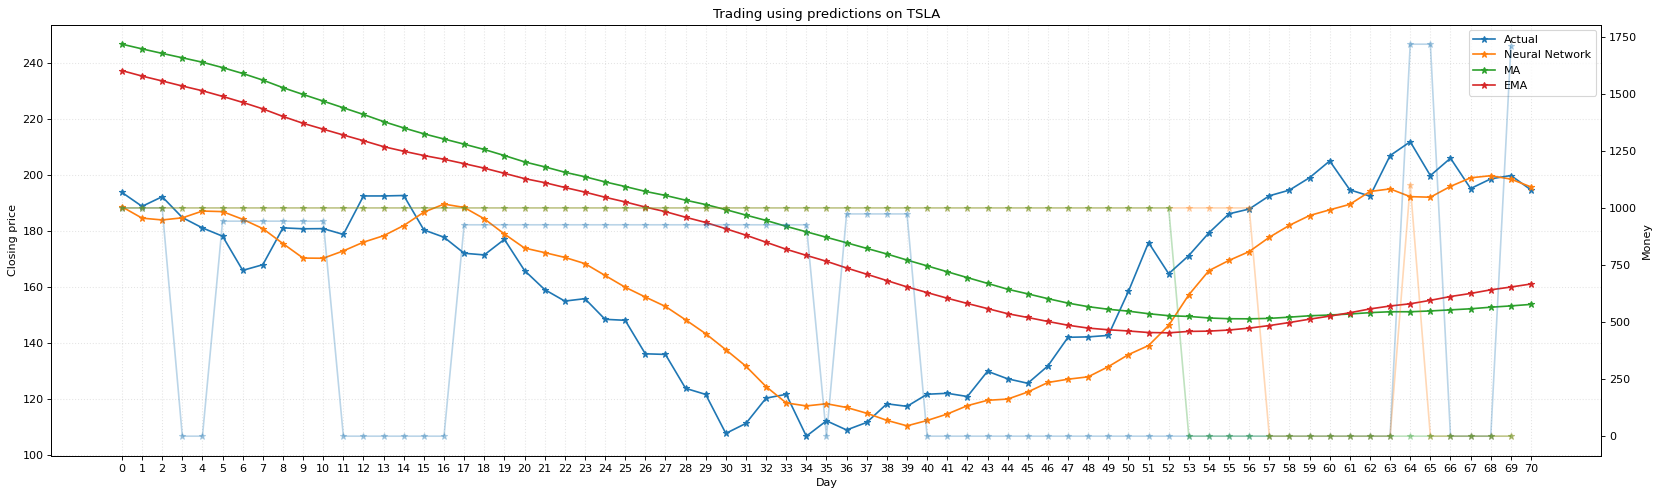

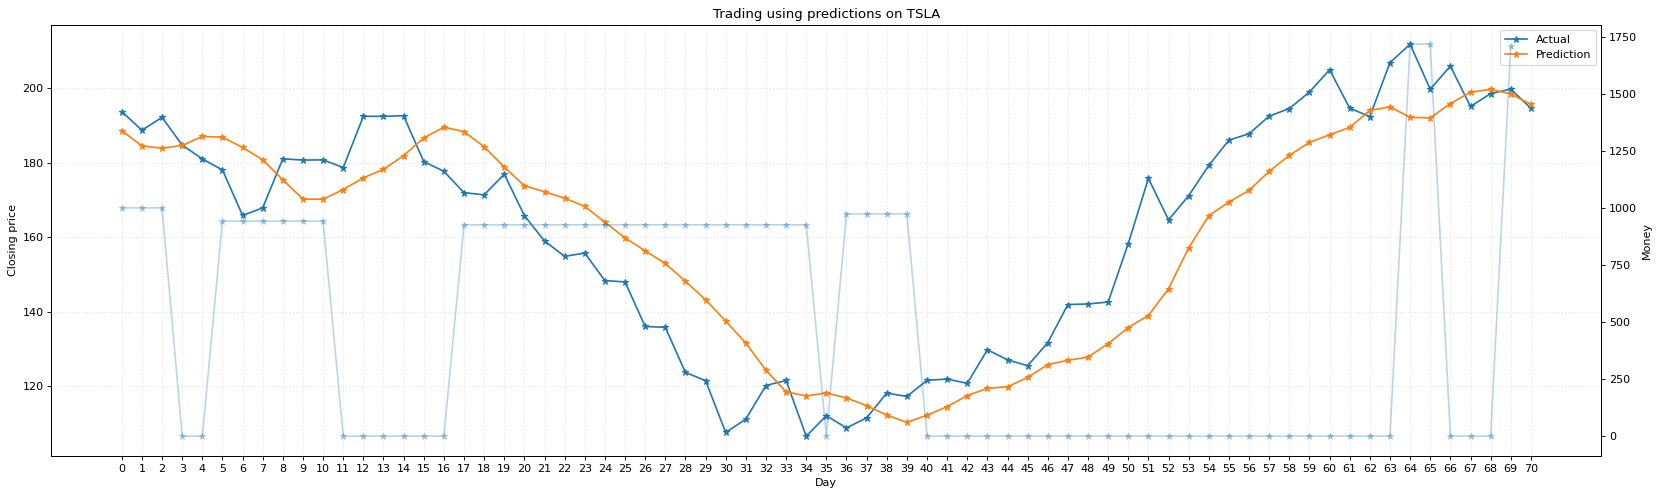

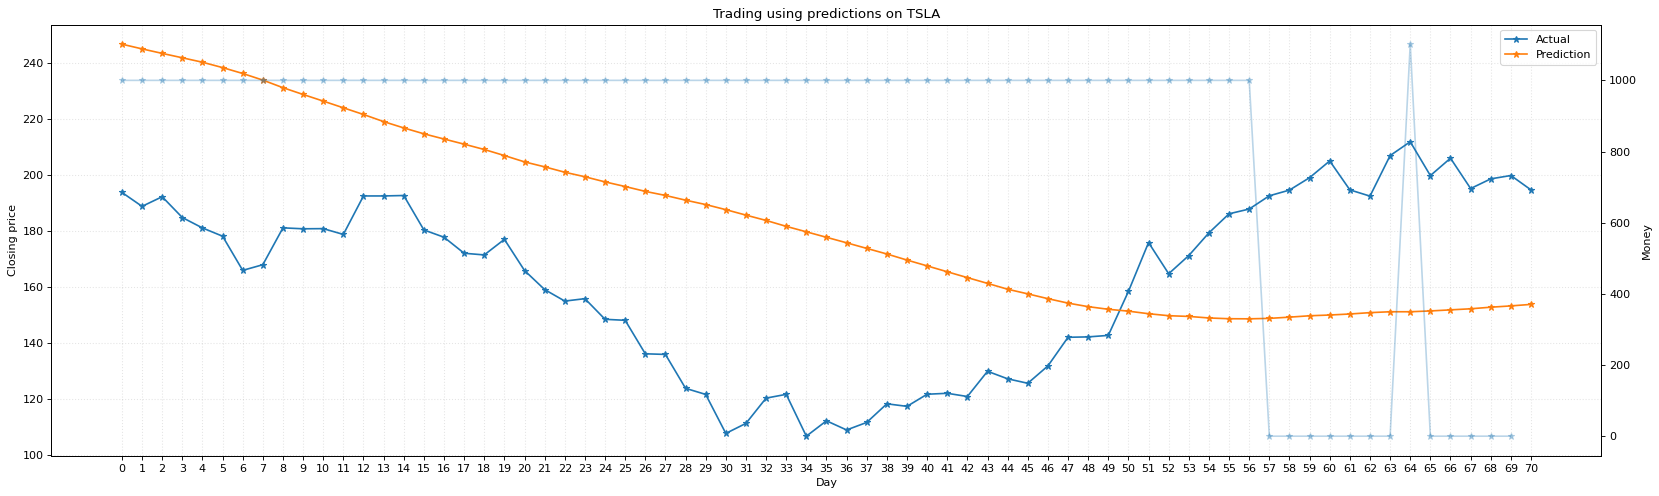

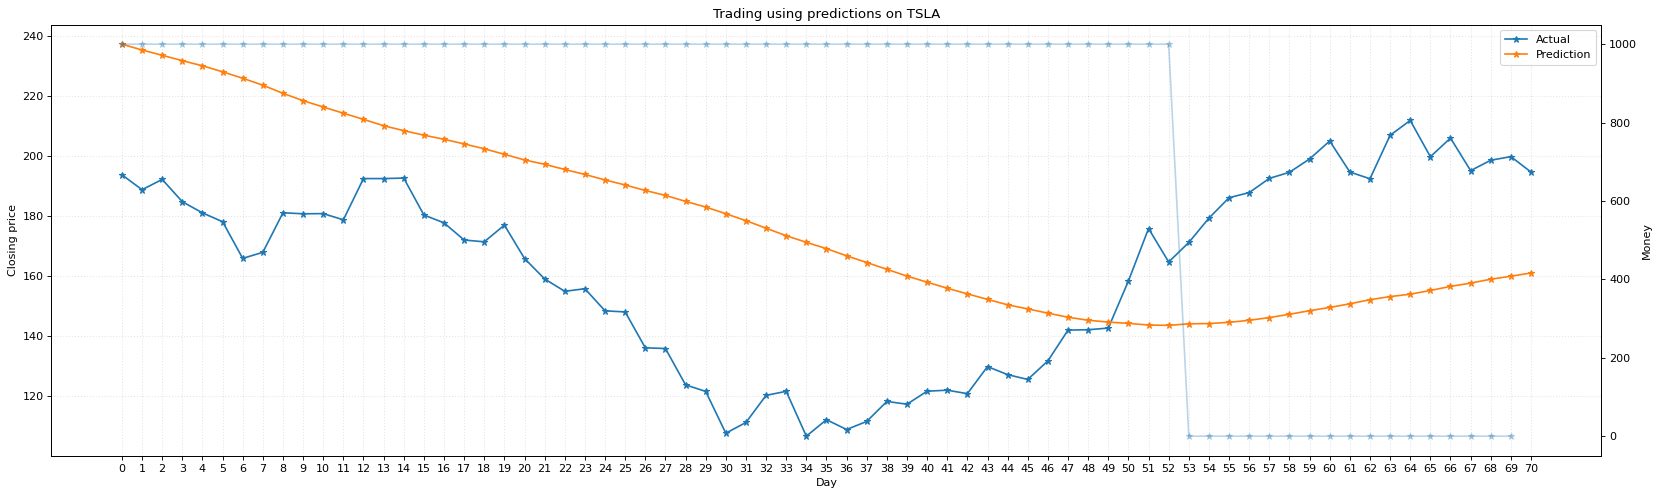

In [41]:
def trader(money, actual, predictions):
    owned_shares = 0
    history = [money]
    
    for i in range(len(predictions)-2):
        # keep track of what is owned
        history.append(money)

        # find out the prices
        # prev_price, curr_price, next_price = actual[i], actual[i+1], predictions[i+2]
        prev_price, curr_price, next_price = predictions[i], predictions[i+1], predictions[i+2]
        # buy
        if prev_price > curr_price and next_price > curr_price:
            if money == 0:
                # print(f"Can't buy {money, owned_shares}")
                continue
            # work out how many shares it buys
            owned_shares = money/actual[i+1]
            money = 0
            # print(f'buy {money, owned_shares}')
        # sell
        elif prev_price < curr_price and next_price < curr_price:
            if owned_shares == 0:
                # print(f"Can't sell {money, owned_shares}")
                continue
            money = owned_shares*actual[i+1]
            owned_shares = 0
            # print(f'sell {money, owned_shares}')
        # hold
        else:
            # print('do nothing')
            continue
    
    return history

def calc_profit(money_history, initial_money):
    # find the last value that wasn't 0
    for i in reversed(range(len(money_history))):
        if money_history[i] != 0:
            # the final value of money
            break # money_history[i] is the final value that isn't 0
    money_made = money_history[i]-initial_money
    percentage = money_made/initial_money*100
    spacing = 0
    spacer = "."
    stats = [f"{percentage:.2f}%".rjust(spacing, spacer),
         f"£ {initial_money:,.2f}".rjust(spacing, spacer),
         f"£ {money_history[i]:,.2f}".rjust(spacing, spacer),
         f"£ {money_made:,.2f}".rjust(spacing, spacer),
         f"£ {money_made/(len(money_history)/30.437):,.2f}".rjust(spacing, spacer)]
    return stats

# plot the trades
def plot_trades(base, plots, alpha = 0.3, hold_on = 1):
    if hold_on:
        # plot the results
        fig, ax1 = plt.subplots(figsize=(25, 7), dpi=80)
        ax1.plot(base, "*-") # actual data
        ax2 = ax1.twinx()
        for plot in plots:
            ax1.plot(plot[0], "*-") # prediction
            ax2.plot(plot[1], "*-", alpha = alpha) # money over time
        ax1.legend("Actual,Neural Network,MA,EMA".split(","))
        ax1.set_ylabel("Closing price")
        # create a second axis
        ax2.set_ylabel("Money")
        # other plotting options
        ax1.set_xlabel("Day")
        plt.xticks(range(len(ytest)))
        ax1.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.1)
        plt.title(f"Trading using predictions on {config['data']['ticker']}")
        plt.show()
    # if not then create a different plot for each data set
    for plot in plots:
        # plot the results
        fig, ax1 = plt.subplots(figsize=(25, 7), dpi=80)
        ax1.plot(base, "*-") # actual data
        ax2 = ax1.twinx()
        ax1.plot(plot[0], "*-") # prediction
        ax2.plot(plot[1], "*-", alpha = alpha) # money over time
        ax1.legend("Actual,Prediction".split(","))
        ax1.set_ylabel("Closing price")
        # create a second axis
        ax2.set_ylabel("Money")
        # other plotting options
        ax1.set_xlabel("Day")
        plt.xticks(range(len(ytest)))
        ax1.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.1)
        plt.title(f"Trading using predictions on {config['data']['ticker']}")
        plt.show()
# initial, final = 40, -1
# ytest = ytest[initial:final]
# pred_ytest = pred_ytest[initial:final]
# pred_MA = pred_MA[initial:final]
# pred_EMA = pred_EMA[initial:final]

initial_money = 1000
nn_money = trader(initial_money, ytest, pred_ytest)
ma_money = trader(initial_money, ytest, pred_ma)
ema_money = trader(initial_money, ytest, pred_ema)
krr_money = trader(initial_money, ytest, pred_krr)
# calcualte and display the results of the trader
d = {"Neural Netowrk": calc_profit(nn_money, initial_money),
     "KRR": calc_profit(krr_money, initial_money),
     "Moving Average": calc_profit(ma_money, initial_money),
     "Exp Moving Average": calc_profit(ema_money, initial_money)
     }
df = pd.DataFrame(d, index = ['Percentage', 'Buy in', 'Cash out', f"{len(nn_money)/5} weeks profit", 'Profit per month'])
display(df) # display the dataframe

to_plot = [[pred_ytest, nn_money],
           [pred_ma, ma_money],
           [pred_ema, ema_money]
           ]
# plot the trading results
plot_trades(ytest, to_plot, 0.3, 1)


TESTS with different parameters

In [111]:
# THIS SETS UP TEST TO BE DONE
tests = {
    # config for the neural network
    "nn": {
        "window": 50, # this is also the window, window size or entries used to predict the future price
        "nLayers": 2, # 2
        "neurons": 256, # 256
        "dropout": 0.3,
        "lossFunc": "huber_loss", # "huber_loss" Huber looss is better to give outliers some weight but not too much, which can be good for predicting asset prices?
        "optimizer": "adam", # "adam"
    },
    "data": {
        "ticker": ["TSLA", ], # "TSLA" "AMZN" "AAPL" "NVDA" "AMD"
        "lookahead": 2,
        "validation": 0.1, # percentage of training data to be used as validation
        "testSize": 0.1, # to test on 
        "scale": True,
    },
    "training": {
        "batch_size": 64, # 64
        "num_epoch": 500, # 500
    }
}
# Neurla networks
windows = [10, 50]
layers = [2]
num_neurons = [256]
dropouts = [0.3]
loss_functions = ["huber_loss"]
optimizers = ["adam"]
# Data stuff
tickers = "TSLA,AMZN".split(",") #"TSLA,AMZN,AAPL,NVDA,AMD".split(",")
lookaheads = [2]
validations = [0.1]
tests = [0.1]
scaled = [True]
# Training
batch_sizes = [64]
epochs = [1, 2]

import itertools
# setup different models
networks = {} # setup a dictionary to save all the models generated
for opts in itertools.product(windows, layers, num_neurons, dropouts, loss_functions, optimizers):
    print(opts)
    # create a model using the options in CONFIG
    model = generateModel(opts[0], opts[1], opts[2], n_features= config["nn"]["nFeatures"], dropout= opts[3], loss= opts[4], optimizer= opts[5], layerType= config["nn"]["layerType"])
    # store the models in a dictionary
    networks[opts] = model

# download all the different data
stocks = {}
for ticker in tickers:
    stocks[ticker] = getData(ticker, config["data"]["offset"])

(10, 2, 256, 0.3, 'huber_loss', 'adam')
(50, 2, 256, 0.3, 'huber_loss', 'adam')
TSLA data has been imported between 2020-02-27 and the 2023-02-27, for a total of 755 days of data
AMZN data has been imported between 2020-02-27 and the 2023-02-27, for a total of 755 days of data


In [112]:
# setup the different data with different settings
# process all the different data
datasets = {}
for opts in itertools.product(tickers, windows, lookaheads, validations, tests, scaled):
    print(opts)
    # process the data with all of the settings
    datasets[opts] = setupData(stocks[opts[0]], opts[1], opts[2], opts[3], opts[4], opts[5], config["data"]["scaler"], config["data"]["inputs"])

('TSLA', 10, 2, 0.1, 0.1, True)
('TSLA', 50, 2, 0.1, 0.1, True)
('AMZN', 10, 2, 0.1, 0.1, True)
('AMZN', 50, 2, 0.1, 0.1, True)


In [113]:
# train the models
trained_nets = {}
for opts in itertools.product(networks.keys(), datasets.keys(), epochs, batch_sizes):
    # only train if the windows match
    if opts[0][0] == opts[1][1]:
        trained_nets[opts] = networks[opts[0]]
        print(opts)
        trained_nets[opts].fit(datasets[opts[1]]["xtrain"], datasets[opts[1]]["ytrain"], batch_size= opts[3], epochs= opts[2], validation_data=(datasets[opts[1]]["xval"], datasets[opts[1]]["yval"]), verbose=1)

# for key, data in m.items():
#     print(key)

# show the results
# for key, data in datasets.items():
#     print(key, data.keys())
#     plots = "trainDates ytrain,valDates yval,testDates ytest"
#     lines = 100
#     fig = plt.figure(figsize=(25, 7), dpi=80)
#     # plot all the different lines
#     for plot in plots.split(","):
#         x, y = plot.split()
#         plt.plot(data[f"{x}"], data[f"{y}"])
#     step = round(len(data["raw"]["adjclose"].keys())/lines)
#     plt.xticks(data["ydates"][::step], rotation='vertical') 
#     # Plot the grid lines
#     plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
#     scaled = lambda x: "Scaled " if x == True else None
#     plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {key}", fontsize=16)
#     # Define the labels for x-axis and y-axis
#     plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
#     plt.xlabel("Date", fontsize=14)
#     plt.legend("Train,Validation,Test".split(","))
#     # show the plot
#     plt.show()

((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 10, 2, 0.1, 0.1, True), 1, 64)


2023-02-27 21:48:57.964316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.181705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.344817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.595692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.790125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.1944

2023-02-27 21:48:59.883107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:59.958030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:00.021562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 143ms/step - loss: 0.0370 - mean_absolute_error: 0.1944 - val_loss: 0.0131 - val_mean_absolute_error: 0.1524
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 10, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
10/10 [==============================] - 0s 39ms/step - loss: 0.0053 - mean_absolute_error: 0.0811 - val_loss: 0.0014 - val_mean_absolute_error: 0.0431
Epoch 2/2
10/10 [==============================] - 0s 39ms/step - loss: 0.0029 - mean_absolute_error: 0.0554 - val_loss: 0.0024 - val_mean_absolute_error: 0.0556
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 10, 2, 0.1, 0.1, True), 1, 64)
10/10 [==============================] - 0s 31ms/step - loss: 0.0031 - mean_absolute_error: 0.0608 - val_loss: 0.0037 - val_mean_absolute_error: 0.0701
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 10, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
10/10 [==============================] - 0s 30ms/step - loss: 0.0028 - mean_absolute_error: 0.0574 - val_loss: 0.00

2023-02-27 21:49:03.446364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:03.654132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:03.805955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:04.049173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/9 [==>...........................] - ETA: 19s - loss: 0.1782 - mean_absolute_error: 0.5589

2023-02-27 21:49:04.304594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.2340

2023-02-27 21:49:05.782343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:05.858981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:05.979124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 227ms/step - loss: 0.0478 - mean_absolute_error: 0.2340 - val_loss: 0.0083 - val_mean_absolute_error: 0.1138
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 50, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
9/9 [==============================] - 0s 55ms/step - loss: 0.0062 - mean_absolute_error: 0.0873 - val_loss: 0.0027 - val_mean_absolute_error: 0.0627
Epoch 2/2
9/9 [==============================] - 0s 52ms/step - loss: 0.0039 - mean_absolute_error: 0.0664 - val_loss: 0.0041 - val_mean_absolute_error: 0.0749
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 50, 2, 0.1, 0.1, True), 1, 64)
9/9 [==============================] - 0s 51ms/step - loss: 0.0038 - mean_absolute_error: 0.0665 - val_loss: 0.0046 - val_mean_absolute_error: 0.0788
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 50, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
9/9 [==============================] - 0s 45ms/step - loss: 0.0029 - mean_absolute_error: 0.0578 - val_loss: 0.0048 - val_m

3/3 [==============================] - 0s 9ms/step


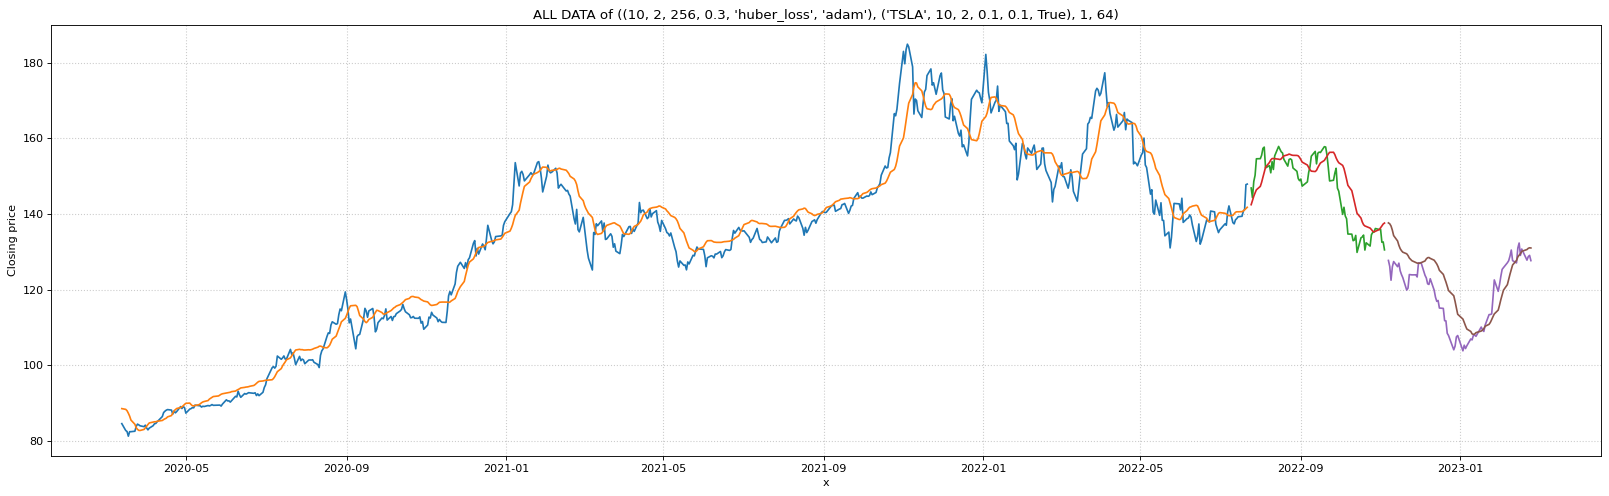

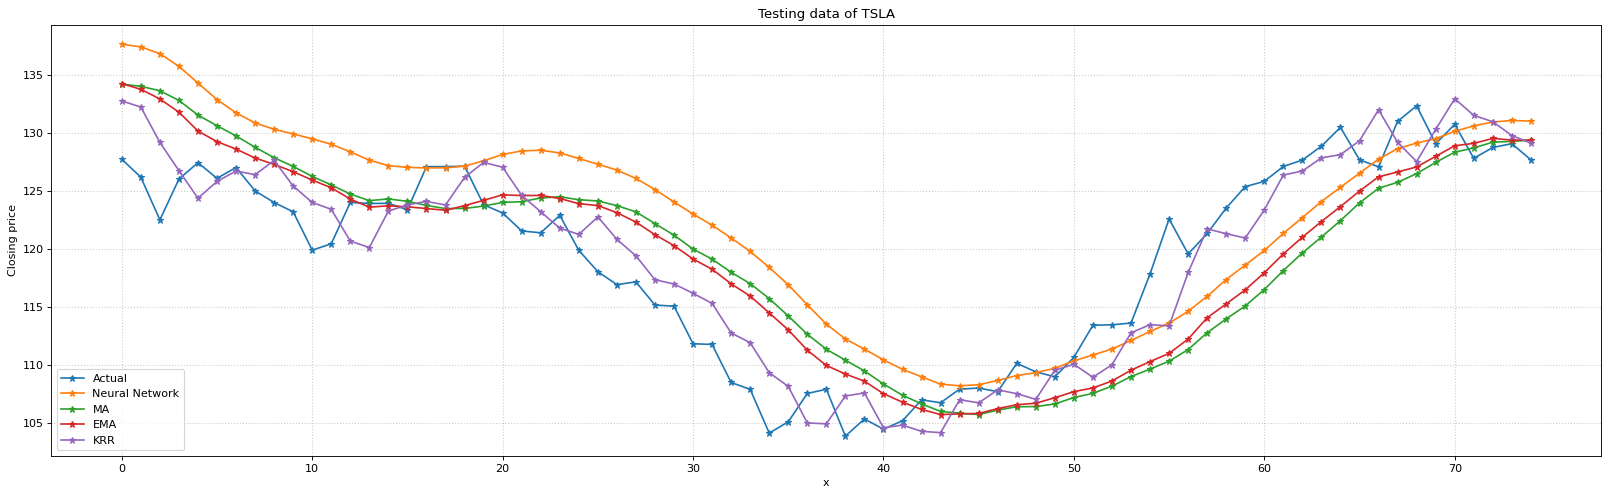

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,27.119308,32.125907,43.076969,9.715144,33.113784,25.897184
RMSE,5.207620,5.667972,6.563305,3.116913,5.754458,5.088928
MAPE,2.811787,3.175840,4.586855,2.188323,4.086181,3.597360
DA,0.533670,0.479452,0.608108,0.554054,0.608108,0.635135
R²,0.956521,0.621400,0.392340,0.862955,0.532885,0.634685


3/3 [==============================] - 0s 7ms/step


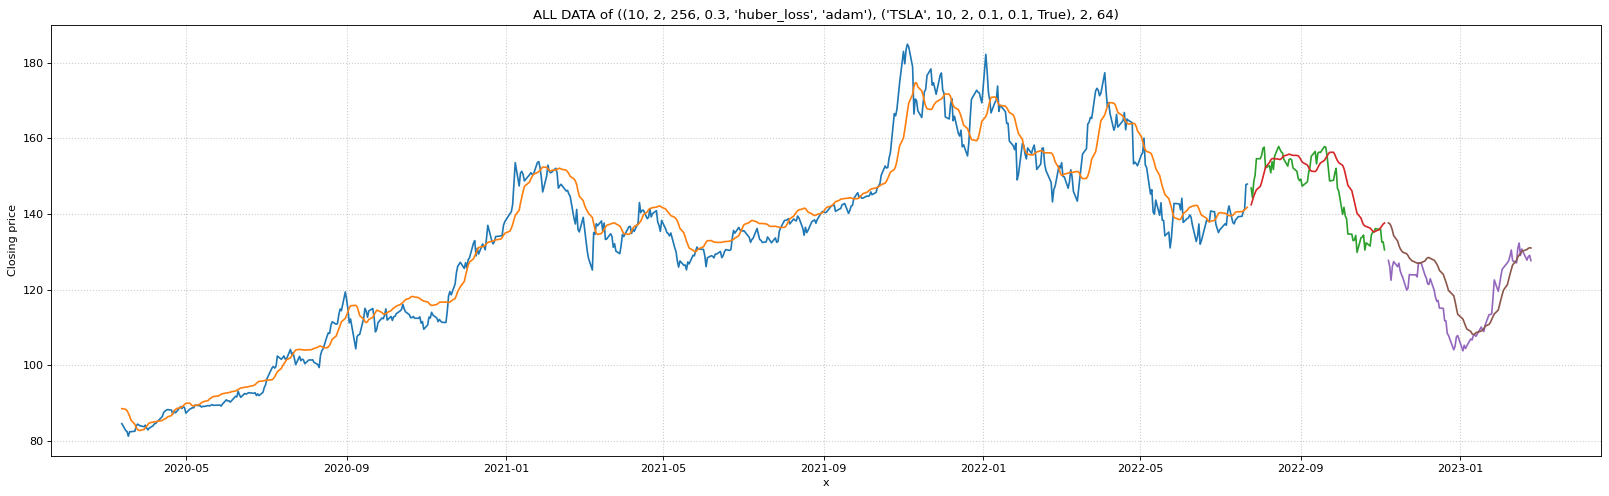

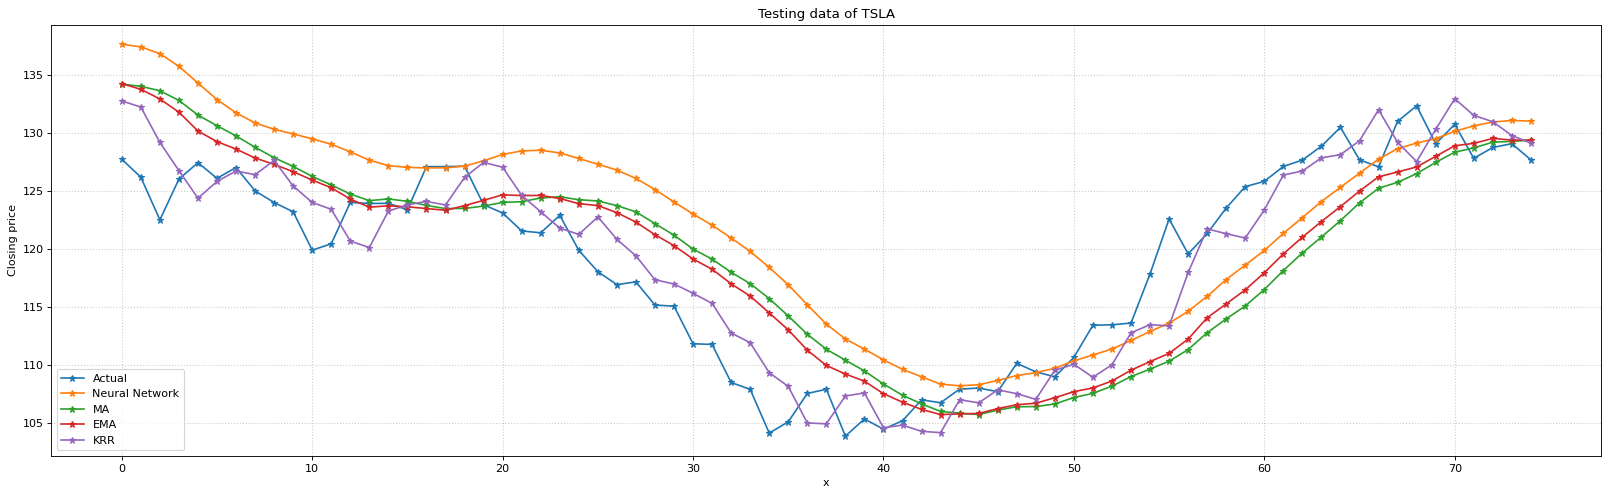

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,27.119308,32.125907,43.076969,9.715144,33.113784,25.897184
RMSE,5.207620,5.667972,6.563305,3.116913,5.754458,5.088928
MAPE,2.811787,3.175840,4.586855,2.188323,4.086181,3.597360
DA,0.533670,0.479452,0.608108,0.554054,0.608108,0.635135
R²,0.956521,0.621400,0.392340,0.862955,0.532885,0.634685


3/3 [==============================] - 0s 9ms/step


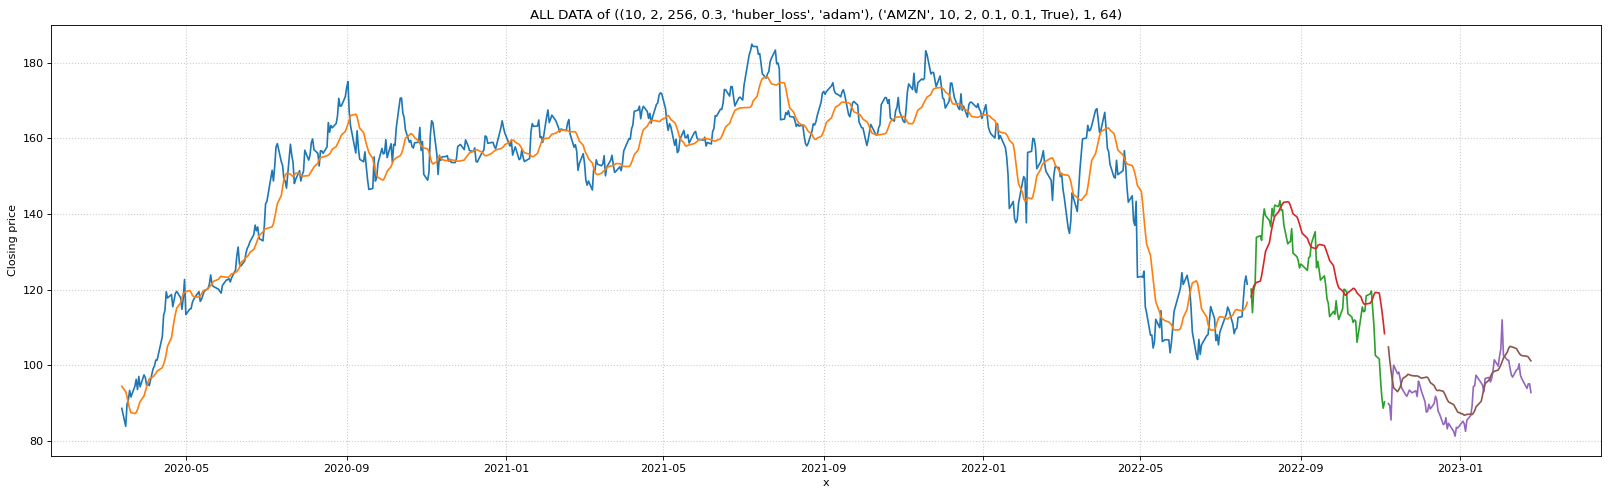

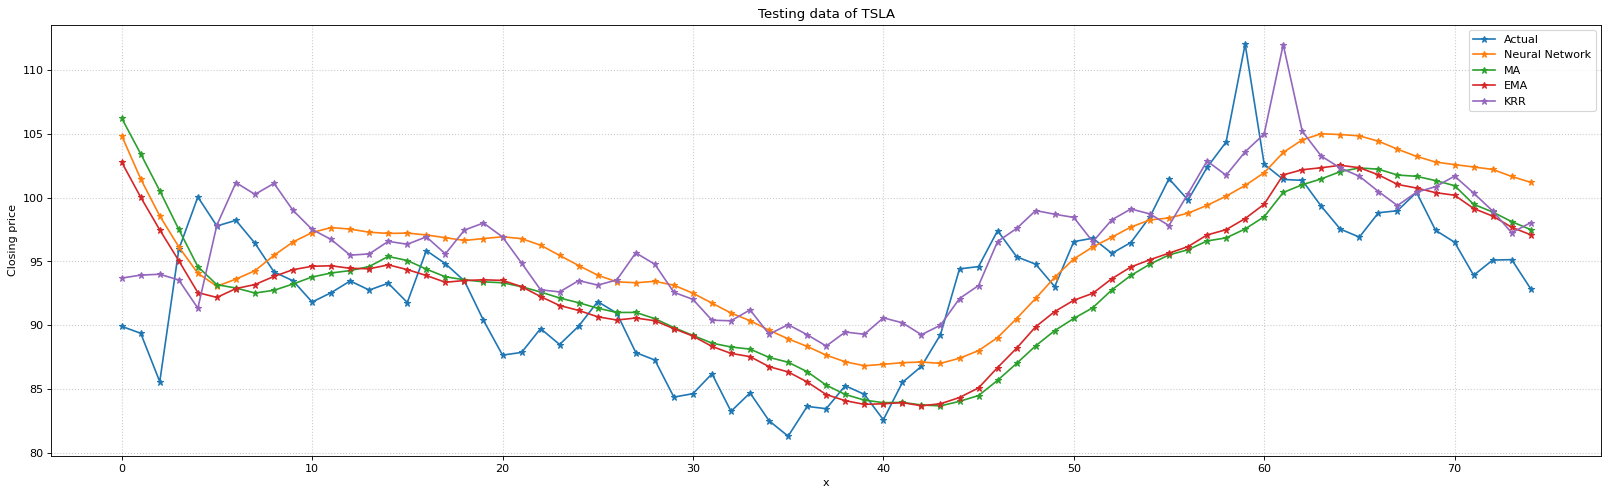

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,44.163843,86.052719,33.586390,23.967551,30.088705,23.878797
RMSE,6.645588,9.276460,5.795377,4.895667,5.485317,4.886594
MAPE,3.468451,6.538713,5.334824,4.572693,4.562467,4.124785
DA,0.491582,0.493151,0.486486,0.445946,0.513514,0.500000
R²,0.907979,0.476810,0.097896,0.356251,0.191841,0.358635


3/3 [==============================] - 0s 11ms/step


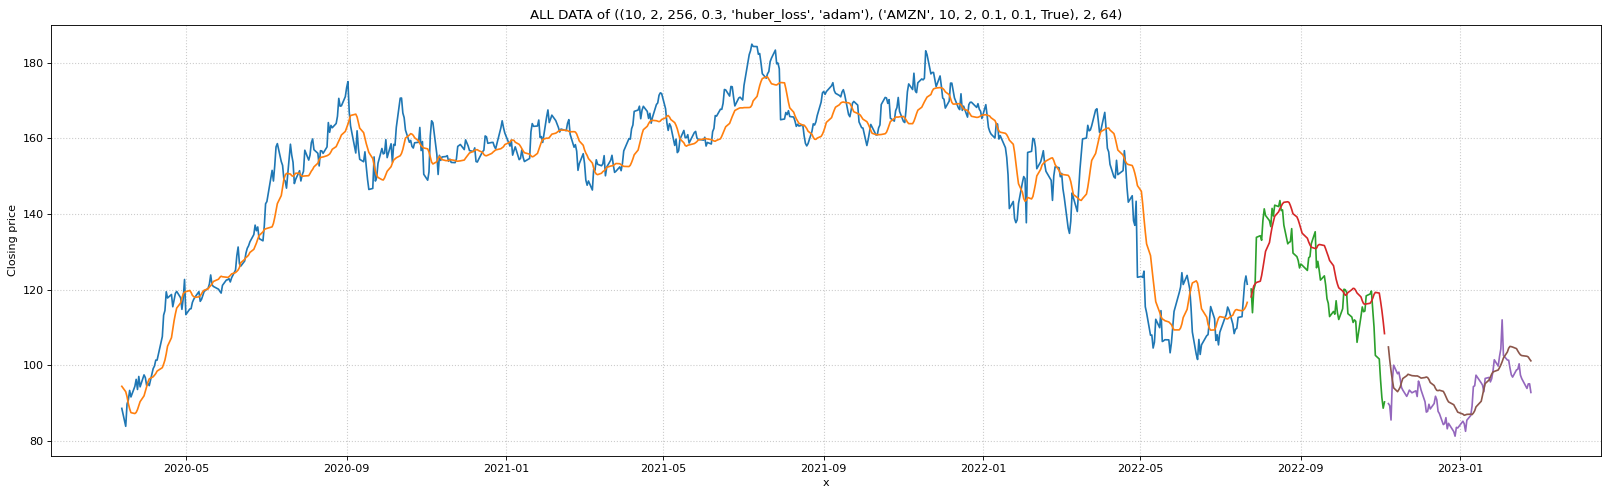

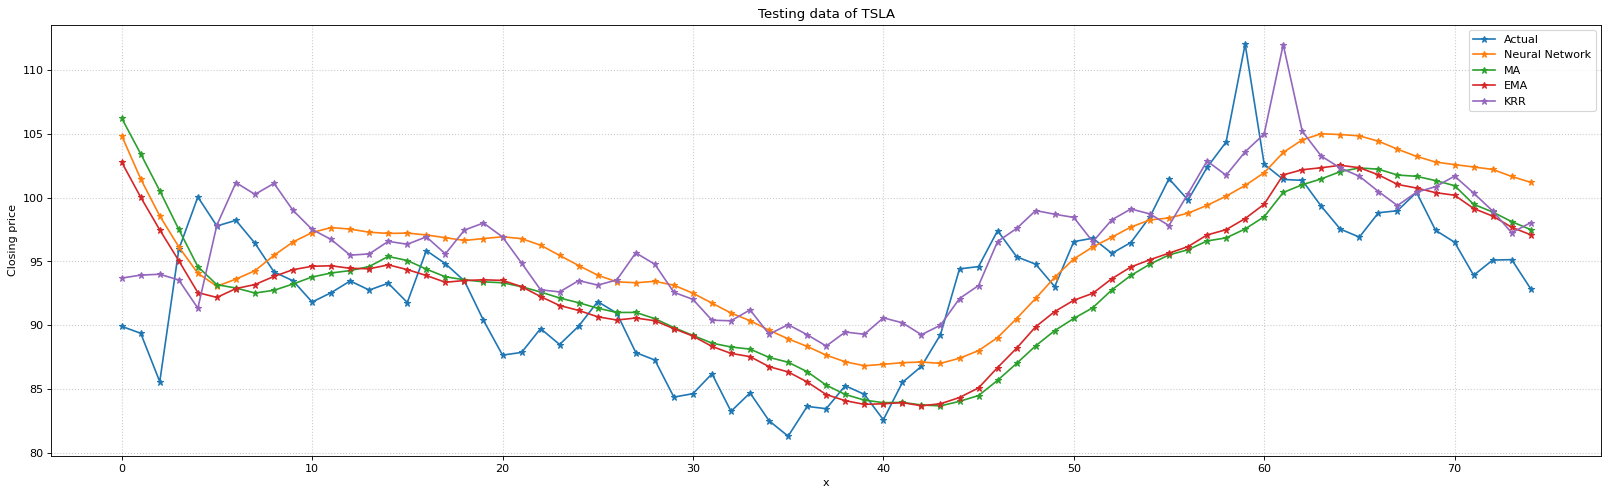

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,44.163843,86.052719,33.586390,23.967551,30.088705,23.878797
RMSE,6.645588,9.276460,5.795377,4.895667,5.485317,4.886594
MAPE,3.468451,6.538713,5.334824,4.572693,4.562467,4.124785
DA,0.491582,0.493151,0.486486,0.445946,0.513514,0.500000
R²,0.907979,0.476810,0.097896,0.356251,0.191841,0.358635


3/3 [==============================] - 0s 28ms/step


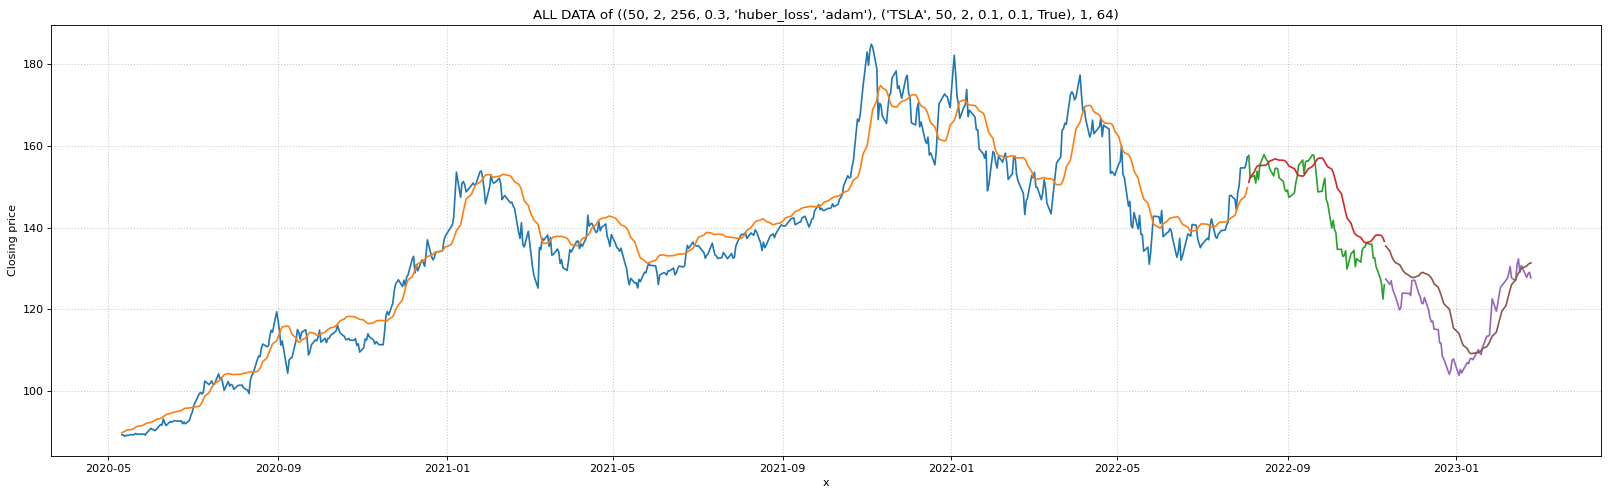

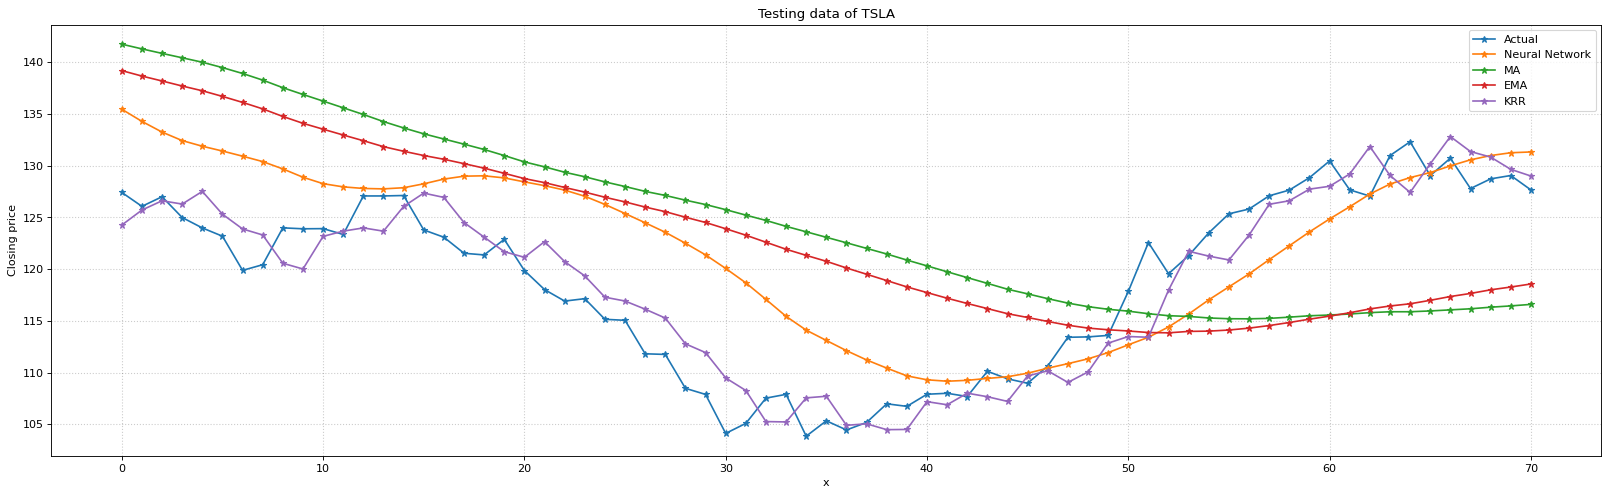

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,32.991605,48.819729,49.949015,8.603780,169.921437,131.947238
RMSE,5.743832,6.987112,7.067462,2.933220,13.035392,11.486829
MAPE,3.139381,3.965914,5.041390,2.080039,10.452921,9.115134
DA,0.540925,0.463768,0.585714,0.542857,0.514286,0.585714
R²,0.933700,0.544219,0.309349,0.881034,-1.349525,-0.824451


3/3 [==============================] - 0s 17ms/step


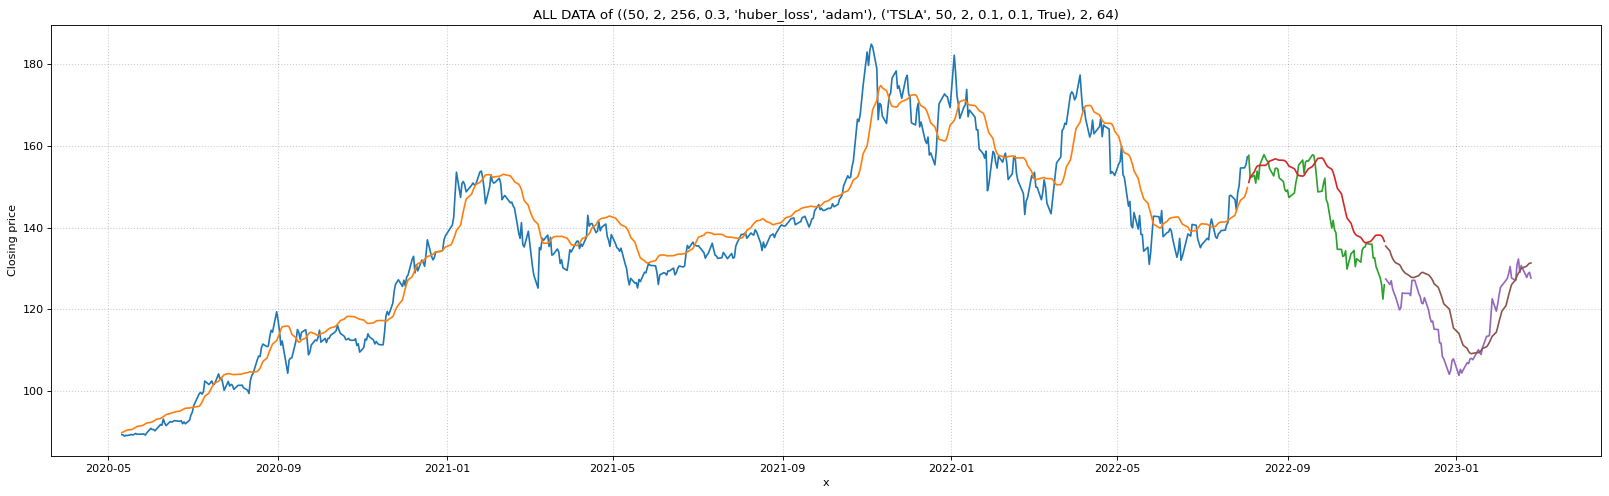

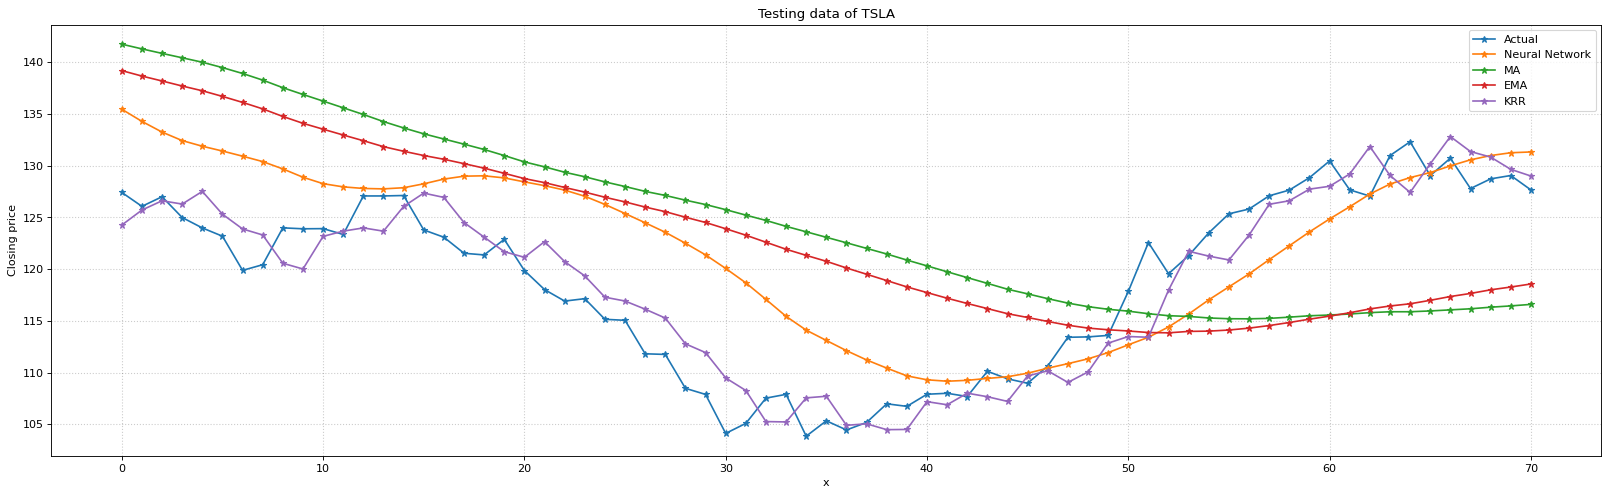

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,32.991605,48.819729,49.949015,8.603780,169.921437,131.947238
RMSE,5.743832,6.987112,7.067462,2.933220,13.035392,11.486829
MAPE,3.139381,3.965914,5.041390,2.080039,10.452921,9.115134
DA,0.540925,0.463768,0.585714,0.542857,0.514286,0.585714
R²,0.933700,0.544219,0.309349,0.881034,-1.349525,-0.824451


3/3 [==============================] - 0s 19ms/step


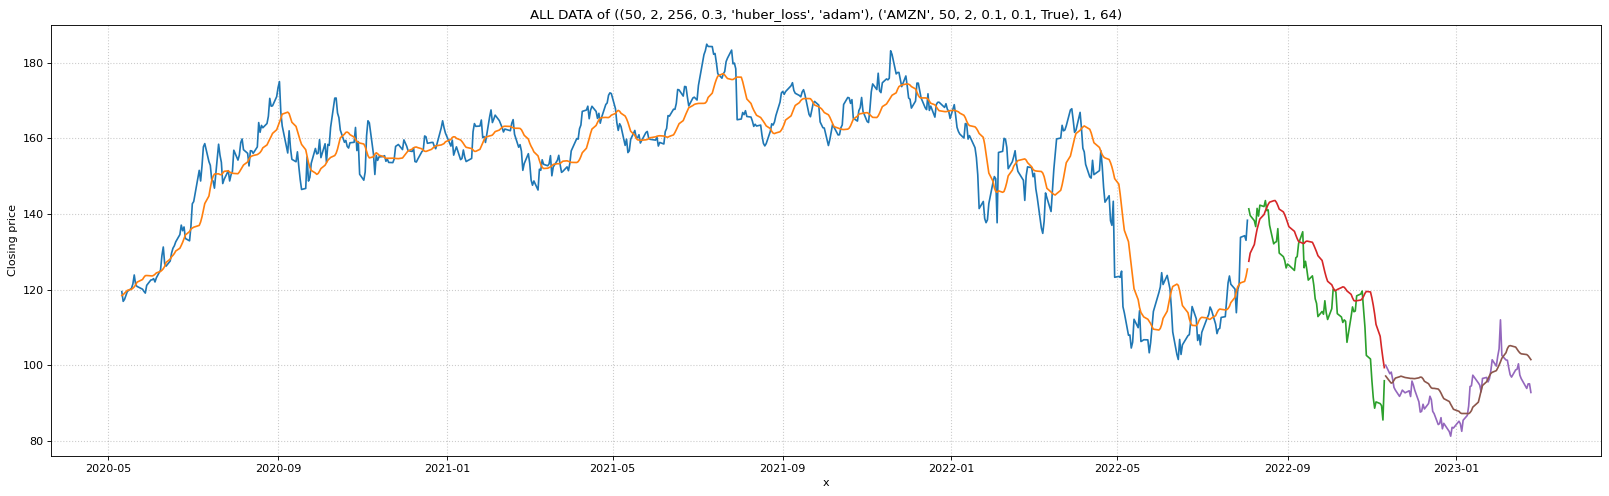

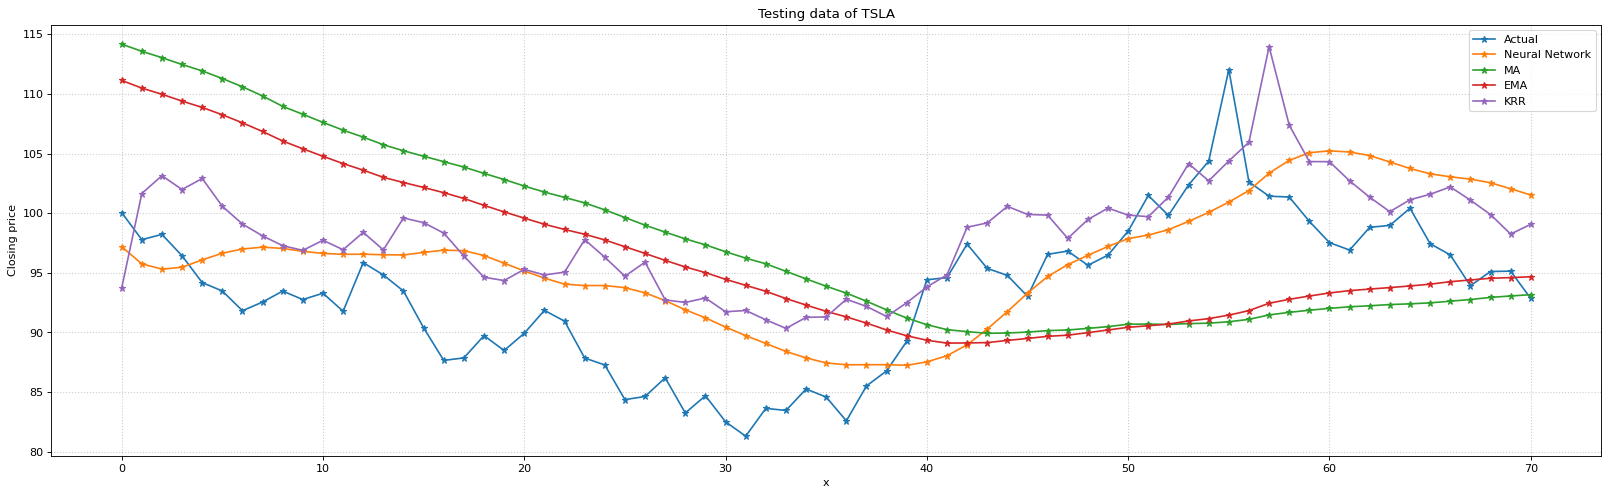

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,47.508294,110.007219,29.531121,37.968501,131.299272,93.997416
RMSE,6.892626,10.488433,5.434254,6.161859,11.458589,9.695226
MAPE,3.484255,7.764645,5.102725,5.979233,11.239135,9.482228
DA,0.491103,0.521739,0.485714,0.500000,0.528571,0.514286
R²,0.866464,0.496209,0.223879,0.002133,-2.450736,-1.470389


3/3 [==============================] - 0s 16ms/step


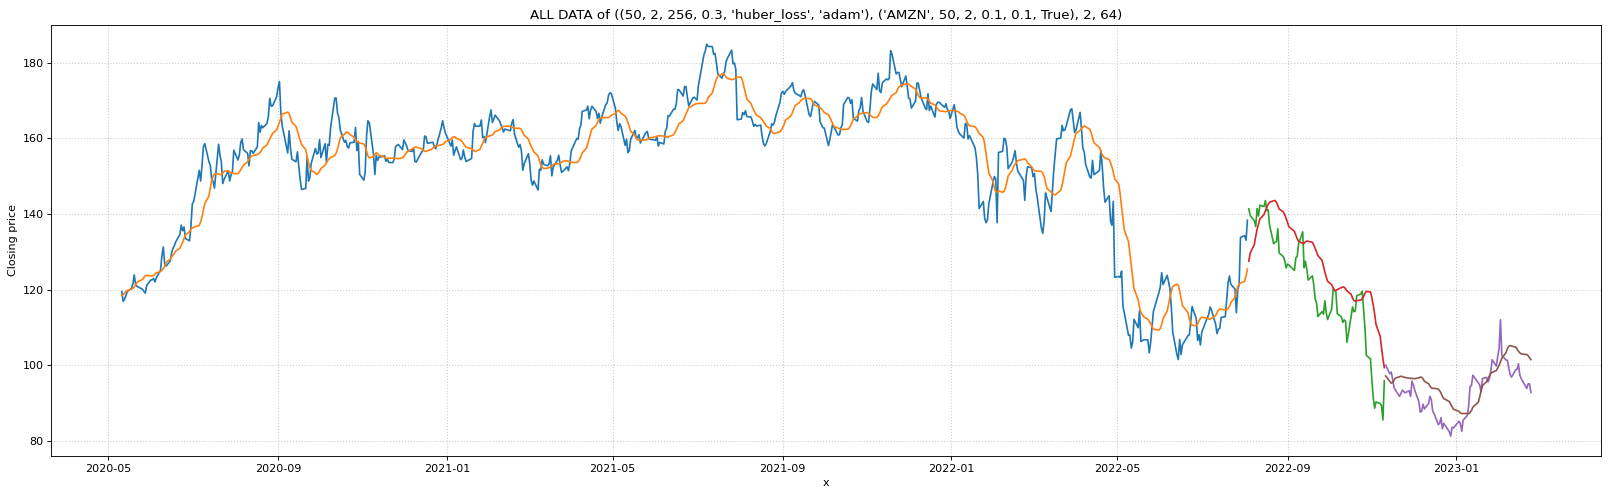

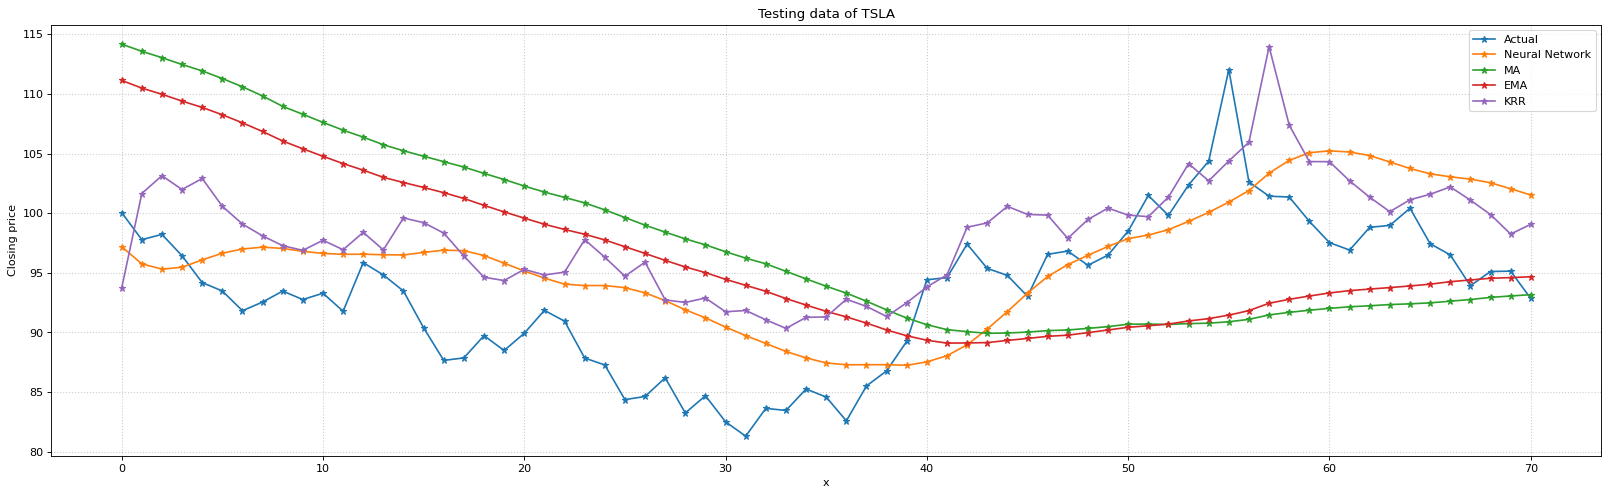

,Training NN,Validation NN,Testing NN,Testing KRR,Testing MA,Testing EMA
MSE,47.508294,110.007219,29.531121,37.968501,131.299272,93.997416
RMSE,6.892626,10.488433,5.434254,6.161859,11.458589,9.695226
MAPE,3.484255,7.764645,5.102725,5.979233,11.239135,9.482228
DA,0.491103,0.521739,0.485714,0.500000,0.528571,0.514286
R²,0.866464,0.496209,0.223879,0.002133,-2.450736,-1.470389


In [123]:
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))

# get results from all the trained networks
for key, net in trained_nets.items():
    model = net
    data = datasets[key[1]]
    # for the training
    pred_ytrain = model.predict(data["xtrain"])
    ytrain = data["ytrain"]
    # scaler = config["data"]["scaler"]
    pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
    ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))

    # for the training
    pred_yval = model.predict(data["xval"])
    yval = data["yval"]
    # scaler = config["data"]["scaler"]
    pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
    yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))

    # for the training
    pred_ytest = model.predict(data["xtest"])
    ytest = data["ytest"]
    # scaler = config["data"]["scaler"]
    pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
    ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))
    # ALL 3 TOGETHER
    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    # for the training
    plt.plot(data["trainDates"],ytrain) # train data
    plt.plot(data["trainDates"], pred_ytrain)
    plt.plot(data["valDates"], yval) # val data
    plt.plot(data["valDates"], pred_yval)
    plt.plot(data["testDates"], ytest) # test data
    plt.plot(data["testDates"], pred_ytest)
    plt.title(f"ALL DATA of {key}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.show()

    # Kernel Ridge Regression
    from sklearn.kernel_ridge import KernelRidge
    krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
    # Train the model on the training data
    krr.fit(data['xtrain'][:, -1, :], data['ytrain'])
    # Make predictions on the test data
    pred_krr = krr.predict(data['xtest'][:, -1, :])
    pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))


    # calcualte the price using a simple moving average
    pred_ma = np.mean(data["xtest"], axis = 1)
    pred_ma = pred_ma[:, 0] # take only the adjclose price out
    pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))

    # calculate the price using exponential moving average
    pred_ema = data["xtest"][:, :, 0] # only take the 
    # pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
    weights = np.exp(np.linspace(-1, 0, key[0][0]))
    weights /= weights.sum()
    pred_ema = pred_ema@weights
    pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))

    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    plt.plot(ytest, "*-") # actual data
    plt.plot(pred_ytest, "*-") # prediction made by neural network
    plt.plot(pred_ma, "*-")
    plt.plot(pred_ema, "*-")
    plt.plot(pred_krr, "*-")
    plt.title(f"Testing data of {config['data']['ticker']}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    xticks = 100
    step = round(len(data["raw"]["adjclose"].keys())/xticks)
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.legend("Actual,Neural Network,MA,EMA,KRR".split(","))
    plt.show()

    # compare all the following data
    pairs = [[ytrain, pred_ytrain, 'Training NN'],
            [yval, pred_yval, 'Validation NN'],
            [ytest, pred_ytest, 'Testing NN'],
            [ytest, pred_krr, 'Testing KRR'],
            [ytest, pred_ma, 'Testing MA'],
            [ytest, pred_ema, 'Testing EMA']
            ]
    d = {}
    for pair in pairs:
        d[pair[2]] = []
        d[pair[2]].append(calc_mse(pair[0], pair[1]))
        d[pair[2]].append(calc_rmse(pair[0], pair[1]))
        # d[pair[2]].append(calc_mae(pair[0], pair[1]))
        d[pair[2]].append(calc_mape(pair[0], pair[1]))
        d[pair[2]].append(calc_da(pair[0], pair[1]))
        d[pair[2]].append(calc_cod(pair[0], pair[1]))

    df = pd.DataFrame(data=d)
    df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²']
    display(df)